## Solve 1D diffusion-advection equation in transient state

In [1]:
import numpy as np
from mpi4py import MPI
import pyvista
import ufl

from ufl import Measure

import dolfinx
from dolfinx import fem, plot
from dolfinx.io import XDMFFile
from dolfinx.fem import FunctionSpace, Constant, Function

from petsc4py import PETSc
from petsc4py.PETSc import ScalarType

## Read the mesh

In [2]:
# Read the mesh
with XDMFFile(MPI.COMM_WORLD, "mesh_rectangle/linear/rectangle_mesh.xdmf", "r") as xdmf:
    mesh = xdmf.read_mesh(name="Grid")
    cell_tags = xdmf.read_meshtags(mesh, name="Grid")
mesh.topology.create_connectivity(mesh.topology.dim-1, mesh.topology.dim)

with XDMFFile(MPI.COMM_WORLD, "mesh_rectangle/linear/rectangle_facet_mesh.xdmf", "r") as xdmf:
    facet_tags = xdmf.read_meshtags(mesh, name="Grid")

## Define temporal parameters

In [3]:
t = 0 # Start time
T = 1200 # 2. # Final time 1
num_steps = 120
dt = T / num_steps # time step size

TL = 5 # initial temperature and temperature on the right hand side
TI = 10 # fixed temperature on the left

## Finite element function space

In [4]:
V = FunctionSpace(mesh, ("CG", 1))  # Lagrange element and and linear elements (degree 1)

## Set initial conditions

In [5]:
T_n = Function(V)
T_n.name = "p_n"
T_n.x.array[:] = np.full(len(T_n.x.array), TL)

## Boundary conditions

In [6]:
# DIRICHLET: T=TL on side 4
boundary_dofs = fem.locate_dofs_topological(V, mesh.topology.dim-1, facet_tags.indices[facet_tags.values == 4])
bc_right = fem.dirichletbc(ScalarType(TL), boundary_dofs, V)
# T=TI on side 3
boundary_dofs = fem.locate_dofs_topological(V, mesh.topology.dim-1, facet_tags.indices[facet_tags.values == 3])
bc_left = fem.dirichletbc(ScalarType(TI), boundary_dofs, V)

bc_tot = [bc_left, bc_right]

# NEUMANN: dp/dn=-4 on the left side (side 3)
# here we only want to integrate on the left side so we can create a custom integration measure ds which only integrates over facets marked with value i
#ds = Measure("ds", domain=mesh, subdomain_data=facet_tags)
#g = -1

## Time-dependent output

In [7]:
T_h = T_n.copy()
T_h.name = "T_h"

## Trial and test functions

In [8]:
T, r = ufl.TrialFunction(V), ufl.TestFunction(V)

## Source term

In [9]:
# here f=0 as there is no source term
f = fem.Constant(mesh, ScalarType(0))

## Variational problem

In [10]:
# physical properties
rho = 1
c = 1
rho_w = 1
c_w = 1
cond = 1e-5 # 0.1 for diffusion # 1e-5 for advection

In [11]:
# fluid flow 
q = Constant(mesh, ScalarType((0.01, 0))) #0.01. # avec qx=5 tout joue bien car la diffusion domine. Mais si on choisit qx=40 l'advection domine et c'est instable.

In [12]:
#a = ufl.dot(ufl.grad(T), ufl.grad(r)) * ufl.dx + ufl.dot(q, ufl.grad(T)) * r * ufl.dx
#L = f * r * ufl.dx - g * r * ds(3)

# pour le moment on peut définir a et L comme ci-dessus, ou similairement comme ci-dessous. Mais pour la suite (implémentation de SUPG) il faudra utiliser exclusivement la forme ci-dessous car 
# on va ajouter une intégrale dont un des termes, le résidu res, contient à la fois des termes linéaires et non-linéaires (des termes avec T et des termes sans). C'est donc plus simple que fenics
# détermine automatiquement quels termes sont linéaires et lesquels sont bilinéaires.
# on définit donc F = a-L et c'est ensuite fenics qui retrouvera a et L.

F = T * r * ufl.dx + dt * cond/(rho*c) * ufl.dot(ufl.grad(T), ufl.grad(r)) * ufl.dx + dt * (rho_w*c_w)/(rho*c) * ufl.dot(q, ufl.grad(T)) * r * ufl.dx \
    - (T_n * r * ufl.dx + dt * f * r * ufl.dx) # - dt * cond/(rho*c) * g * r * ds(3))

In [13]:
# add SUPG
tdim = mesh.topology.dim
num_cells = mesh.topology.index_map(tdim).size_local
h = dolfinx.cpp.mesh.h(mesh, tdim, range(num_cells))
h_av = np.mean(h)

# res =  T - T_n + dt*(ufl.dot(q, ufl.grad(T)) - ufl.div(ufl.grad(T)) - f)
res =  T - T_n + dt*((rho_w*c_w)/(rho*c)*ufl.dot(q, ufl.grad(T)) - cond/(rho*c)*ufl.div(ufl.grad(T)) - f)

qnorm = ufl.sqrt(ufl.dot(q, q))
tau = h_av/(2*qnorm)  #2

F += tau * ufl.dot(q, ufl.grad(r)) * res * ufl.dx

In [14]:
a = ufl.lhs(F)
L = ufl.rhs(F)

## Preparation of linear algebra structures for time dependent problems

In [15]:
bilinear_form = fem.form(a)
linear_form = fem.form(L)

In [16]:
# bilinear_form (a) isn't time dependant so we can assemble it once (we could do the same for the integral of the Neumann term as the flux is contant, but for now let's stay like that)
A = fem.petsc.assemble_matrix(bilinear_form, bcs=bc_tot)
A.assemble()
b = fem.petsc.create_vector(linear_form)

## Linear solver

In [17]:
# here matrix A is already assembled so we don't need to use petsc.LinearProblem like in tuto1
solver = PETSc.KSP().create(mesh.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

In [18]:
import pyvista
pyvista.set_jupyter_backend("ipygany")

grid = pyvista.UnstructuredGrid(*plot.create_vtk_mesh(V))

def plot_function(t, uh):
    """
    Create a figure of the concentration uh warped visualized in 3D at timet step t.
    """
    p = pyvista.Plotter()
    # Update point values on pyvista grid
    grid.point_data[f"u({t})"] = uh.x.array.real
    # Warp mesh by point values
    warped = grid.warp_by_scalar(f"u({t})", factor=1.5)

    # Add mesh to plotter and visualize in notebook or save as figure
    actor = p.add_mesh(warped)
    if not pyvista.OFF_SCREEN:
        p.show()
    else:
        pyvista.start_xvfb()
        figure_as_array = p.screenshot(f"diffusion_{t:.2f}.png")
        # Clear plotter for next plot
        p.remove_actor(actor)
plot_function(0, T_h)

AppLayout(children=(VBox(children=(HTML(value='<h3>u(0)</h3>'), Dropdown(description='Colormap:', options={'Br…

In [19]:
T_bottom_vec = [] # for saving
for i in range(num_steps):
    t += dt

    # Update the right hand side reusing the initial vector
    with b.localForm() as loc_b:
        loc_b.set(0)
    fem.petsc.assemble_vector(b, linear_form)
    
    # Apply Dirichlet boundary condition to the vector
    fem.petsc.apply_lifting(b, [bilinear_form], [bc_tot])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b, bc_tot)

    # Solve linear problem
    solver.solve(b, T_h.vector)
    T_h.x.scatter_forward()

    # Update solution at previous time step (u_n)
    T_n.x.array[:] = T_h.x.array

    # Plot every 15th time step
    if i % 15 == 0:
        plot_function(t, T_h)
        
        
    #if t == 10 or t == 100 or t == 300 or t == 1000:  # for diffusion plot
    #if t == 100 or t == 300 or t == 500 or t == 1000:  # for advection plot
    if t == 100 or t == 300 or t == 500 or t == 1200:  # for SUPG plot
        # also save the values
        T_bottom_vec.append(T_h.x.array[mesh.geometry.x[:,1]==0])

AppLayout(children=(VBox(children=(HTML(value='<h3>u(10.0)</h3>'), Dropdown(description='Colormap:', options={…

AppLayout(children=(VBox(children=(HTML(value='<h3>u(160.0)</h3>'), Dropdown(description='Colormap:', options=…

AppLayout(children=(VBox(children=(HTML(value='<h3>u(310.0)</h3>'), Dropdown(description='Colormap:', options=…

AppLayout(children=(VBox(children=(HTML(value='<h3>u(460.0)</h3>'), Dropdown(description='Colormap:', options=…

AppLayout(children=(VBox(children=(HTML(value='<h3>u(610.0)</h3>'), Dropdown(description='Colormap:', options=…

AppLayout(children=(VBox(children=(HTML(value='<h3>u(760.0)</h3>'), Dropdown(description='Colormap:', options=…

AppLayout(children=(VBox(children=(HTML(value='<h3>u(910.0)</h3>'), Dropdown(description='Colormap:', options=…

AppLayout(children=(VBox(children=(HTML(value='<h3>u(1060.0)</h3>'), Dropdown(description='Colormap:', options…

## Compute Péclet number 

In [20]:
tdim = mesh.topology.dim
num_cells = mesh.topology.index_map(tdim).size_local
h = dolfinx.cpp.mesh.h(mesh, tdim, range(num_cells))
h_av = np.mean(h)
Pe = rho_w*c_w*q.value[0]*h_av/cond
Pe

202.96259515966432

## Post-processing

In [21]:
import matplotlib.pyplot as plt

In [22]:
# analytical solution for a 1D diffusion in steady state
def T_analytical(x):
    return [TI]*len(x)

In [23]:
# look for the temperature on L_bottom
x_bottom = mesh.geometry.x[mesh.geometry.x[:,1]==0][:,0]
#T_bottom = T_h.x.array[mesh.geometry.x[:,1]==0]
# sort these temperatures according to the radial distance from point A 
index_order = np.argsort(x_bottom)
x_numerical = x_bottom[index_order]
for ind, T_bottom in enumerate(T_bottom_vec):
    T_bottom_vec[ind] = T_bottom[index_order]
len(T_bottom_vec)

4

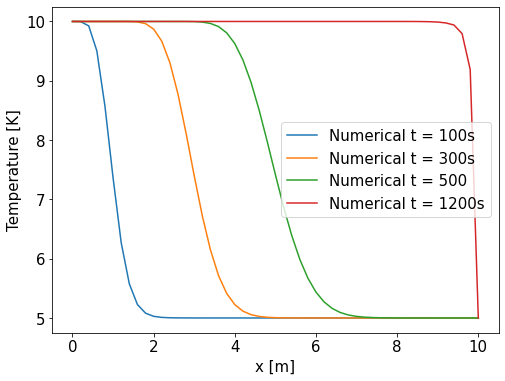

In [24]:
# plot with matplotlib

# x axis for analytical solution
x = np.arange(0., 10., 0.01)

# plot
plt.figure(figsize=(8, 6))
#plt.plot(x, T_analytical(x), 'r-')
for ind, T_bottom in enumerate(T_bottom_vec):
    plt.plot(x_numerical, T_bottom, '-')
#plt.legend(['Numerical t = 10s', 'Numerical t = 100s', 'Numerical t = 300', 'Numerical t = 1000s'], loc='upper right', fontsize = 15) # for diffusion plot
#plt.legend(['Numerical t = 100s', 'Numerical t = 300s', 'Numerical t = 500', 'Numerical t = 1000s'], loc='top left', fontsize = 15) # for advection plot
#plt.legend(['Numerical t = 100s', 'Numerical t = 300s', 'Numerical t = 500', 'Numerical t = 1200s'], loc='upper left', fontsize = 15) # for SUPG plot
plt.legend(['Numerical t = 100s', 'Numerical t = 300s', 'Numerical t = 500', 'Numerical t = 1200s'], loc='right', fontsize = 15) # for SUPG plot
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('x [m]', fontsize=15)
plt.ylabel('Temperature [K]', fontsize=15) 
plt.savefig("advection_injection.png", )
plt.show()